# Fetch and Parcellate Neurosynth Meta-Analyses (for 123 cognitive atlas terms)

This notebook is adapted from [Justine Hansen's tutorial]('https://github.com/netneurolab/ipn-summer-school/blob/main/lectures/2021-07-02/13-15/fetch_and_parcellate_neurosynth.ipynb') for fetching and parcellating Neurosynth terms. *Note that Neurosynth's package is now deprecated, so all of this code has been refactored using NiMARE!*

Script for fetching and parcellating Neurosynth meta-analyses (association tests) for 123 cognitive atlas terms. Terms will be parcellated according to the 200-node Schaefer 2018 7-network and 360-node Glasser (HCP-MMP) parcellations.

This notebook will take approximately 25 minutes to run.

In [ ]:

"""
Script for performing NeuroSynth-style meta-analyses for all available
Cognitive Atlas concepts. Script modified from https://github.com/netneurolab/
markello_spatialnulls/blob/master/scripts/empirical/fetch_neurosynth_maps.py,
for the IPN Summer School > Quantitative and Computational Neuroscience >
Advanced Analytics for Neuroscience > Contextualizing Results lecture.
"""

!pip install nilearn
!pip install --upgrade scipy matplotlib pandas
!pip install nibabel ply
!pip install nimare # now using nimare to access neurosynth database due to neurosynth deprecation
!pip install hcp_utils
!pip install numpy==1.24 # need 1.24 for NiMARE
!pip install chardet
!pip install charset-normalizer
!pip install Bio
!pip install nltools

!pip install netneurotools


Import stuff.
If you run into errors, check if you need to `!pip install --upgrade` or `pip install`. 
(You shouldn't, but who knows.)
 

In [1]:
import pandas as pd
pd.__version__

'2.0.3'

In [2]:
import scipy
scipy.__version__

'1.10.1'

In [3]:
import numpy as np
np.__version__ # we want 1.24.0 for NiMARE

'1.24.0'

In [4]:
import gzip
import pickle

In [5]:
import Bio 
import contextlib
import hcp_utils as hcp
#from hcp_utils import atlas

import json
from nilearn.input_data import NiftiLabelsMasker
from nilearn._utils import check_niimg
from nilearn import datasets, image, plotting
from nilearn.datasets import fetch_atlas_schaefer_2018
from nimare.extract import download_abstracts, fetch_neuroquery, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nimare.correct import FDRCorrector
from nimare.dataset import Dataset
from nimare.meta.cbma.mkda import MKDAChi2
#from nltools import Brain_Data
from neuromaps import images, datasets, images, nulls, resampling, stats, transforms
from neuromaps.datasets import fetch_annotation


import os
import pandas as pd
from pathlib import Path
from pprint import pprint
import requests
import re
from scipy import sparse
import warnings

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/audluo/anaconda3/envs/tractmaps/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Some directory set-up and warning ignoring.

In [6]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# this is where the raw and parcellated data will be stored
NSDIR = Path('./data/raw/neurosynth').resolve()
PARDIR = Path('./data/derivatives').resolve()

# these are the images from the neurosynth-style NiMARE analyses we'll save
IMAGES = ['z_desc-specificity_level-voxel_corr-FDR_method-indep']

All the functions!

In [7]:
def get_cogatlas_concepts(url=None):
    """ Fetches list of concepts from the Cognitive Atlas
    Parameters
    ----------
    url : str
        URL to Cognitive Atlas API
    Returns
    -------
    concepts : set
        Unordered set of terms
    """

    if url is None:
        url = 'https://cognitiveatlas.org/api/v-alpha/concept'

    req = requests.get(url)
    req.raise_for_status()
    concepts = set([f.get('name') for f in json.loads(req.content)])

    return concepts


def fetch_ns_data(directory): # may delete or completely change 
    """ Fetches NeuroSynth database   
    Parameters
    -----------
    directory : str or os.PathLike
        Path to directory where data should be saved
    Returns
    -------
    database, features : PathLike
        Paths to downloaded NS data
    """

    directory = Path(directory)

    # NS data should already be downloaded using NiMARE
    database, features = directory / 'database.txt', directory / 'features.txt'
    return database, features


def run_meta_analyses(database, use_features=None, outdir=None):
    """
    Runs NiMARE-style meta-analysis based on `database` and `features`
    Parameters
    ----------
    database, features : str or os.PathLike
        Path to NS-style database.txt and features.txt files
    use_features : list, optional
        List of features on which to run NS meta-analyses; if not supplied all
        terms in `features` will be used
    outdir : str or os.PathLike
        Path to output directory where derived files should be saved
    Returns
    -------
    generated : list of str
        List of filepaths to generated term meta-analysis directories
    """

    # check outdir
    if outdir is None:
        outdir = NSDIR
    outdir = Path(outdir)
    
    # NiMARE database should already be made
    # Load feature names 
    all_labels = set(database.get_labels())
    stripped_labels = [f.replace("terms_abstract_tfidf__", "") for f in all_labels] 
    features = stripped_labels
    
    # if we only want a subset of the features take the set intersection
    if use_features is not None:
        features = set(stripped_labels) & set(use_features)
        prefixed_features = set("terms_abstract_tfidf__" + feature for feature in features)    
    pad = max([len(f) for f in features])

    generated = []
    for label in sorted(prefixed_features): # label = 'terms_abstract_tfidf__'+ cognitive term
        word = label[len("terms_abstract_tfidf__"):] # the cognitive term
        word = word.replace(' ', '_')
        msg = f'Running meta-analysis for term: {word:<{pad}}'
        print(msg, end='\r', flush=True)

        # run meta-analysis + save specified outputs (only if they don't exist)
        path = outdir / word.replace(' ', '_')
        path.mkdir(exist_ok=True)
        if not all((path / f'{f}.nii.gz').exists() for f in IMAGES):
            # get list of ids for each term of interest 
            selected_ids = []
            ids = database.get_studies_by_label(label, 0.05)
            selected_ids += ids

            # Select studies with term of interest
            # Note: dset_sel includes datasets that have the term in cogatlas_concepts, 
            # but these same datasets may also have additional terms/features
            dset_sel = database.slice(selected_ids) 

            # Select studies without term of interest
            no_term_ids = list(set(database.ids).difference(selected_ids))
            dset_unsel = database.slice(no_term_ids)
            
            # Do Multilevel kernel density analysis- Chi-square analysis 
            # (NiMARE's estimator that matches Neurosynth's MetaAanalysis class)
            mkda = MKDAChi2(kernel__r=10)
            results = mkda.fit(dset_sel, dset_unsel)
            
            # FDR correction
            corr = FDRCorrector(method="indep", alpha=0.05)
            cres = corr.transform(results)
            
            # save out specificity z-value map 
            cres.save_maps(path, names = ["z_desc-specificity_level-voxel_corr-FDR_method-indep"])

        # store MA path
        generated.append(path)

    print(' ' * len(msg) + '\b' * len(msg), end='', flush=True)

    return generated

 
def apply_transformation(input_img_path):
    # use neuromaps function to transform volumetric to surface space
    fslr = transforms.mni152_to_fslr(input_img_path, '32k')
    fslr_lh, fslr_rh = fslr
    return fslr

 
def parcellate_meta(outputs, annots, fname, regions):
    # empty dataframe to hold our parcellated data
    data = pd.DataFrame(index=regions)
    mask = NiftiLabelsMasker(annots, resampling_target='data')

    for outdir in outputs:
        cdata = []
        mgh = outdir / 'z_desc-specificity_level-voxel_corr-FDR_method-indep.nii.gz'

        cdata.append(mask.fit_transform(
            check_niimg(mgh.__str__(), atleast_4d=True)).squeeze())

        # store it in the dataframe
        data = data.assign(**{outdir.name: np.hstack(cdata)})

    # now we save the dataframe! wooo data!
    data.to_csv(fname, sep=',')
    return fname

Download NeuroSynth using NiMARE functions. Neurosynth’s data files are stored at https://github.com/neurosynth/neurosynth-data.


In [8]:
out_dir = os.path.abspath("./data/raw")
os.makedirs(out_dir, exist_ok=True)

files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="terms",
)
# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
pprint(files)
neurosynth_db = files[0]

File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
[{'coordinates': '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/data-neurosynth_version-7_coordinates.tsv.gz',
  'features': [{'features': '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/data-neurosynth_version-7_vocab-terms_source-abstract_type-tfidf_features.npz',
                'vocabulary': '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/data-neurosynth_version-7_vocab-terms_vocabulary.txt'}],
  'metadata': '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/data-neurosynth_version-7_metadata.tsv.gz'}]


Convert Neurosynth database to NiMARE dataset file.

In [ ]:
neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
neurosynth_dset.save(os.path.join(NSDIR, "neurosynth_dataset.pkl.gz"))
print(neurosynth_dset)

neurosynth_dset = download_abstracts(neurosynth_dset, "audrey.luo@pennmedicine.upenn.edu")
neurosynth_dset.save(os.path.join(NSDIR, "neurosynth_dataset_with_abstracts.pkl.gz"))

Run meta-analysis!

In [9]:
with gzip.open(os.path.join(NSDIR, "neurosynth_dataset_with_abstracts.pkl.gz"), 'rb') as f:
    neurosynth_dset = pickle.load(f)
    
NSDIR.mkdir(parents=True, exist_ok=True)
PARDIR.mkdir(parents=True, exist_ok=True)

# get concepts from CogAtlas and run relevant NS meta-analysess,

generated = run_meta_analyses(neurosynth_dset, get_cogatlas_concepts())


[PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/adaptation'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/addiction'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/anticipation'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/anxiety'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/arousal'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/association'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/attention'),
 PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/autobiographical_memory')]

In [10]:
# Function to modify the path
def modify_path(path):
    return path.parent.parent / 'neurosynth' / path.name

# Create a new list of modified path
modified_paths = [Path(modify_path(path)) for path in generated]



In [10]:


metaanalyses_dir = "/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth"

 

for folder_name in os.listdir(metaanalyses_dir):
    folder_path = os.path.join(metaanalyses_dir, folder_name)
    if os.path.isdir(folder_path):
        # Iterate through files in the subfolder
        for filename in os.listdir(folder_path):
            if filename.endswith(".nii.gz"):
                # Construct the full path to the NIfTI file
                nii_path = os.path.join(folder_path, filename)
                
                # Apply the transformation function
                transformed_img = apply_transformation(nii_path)
            
                # Define output gifti
                output_files = ("output_file_lh.shape.gii", "output_file_rh.shape.gii") 
                
                # Save the transformed image 
                for gifti_image, output_file in zip(transformed_img, output_files):
                    nib.save(gifti_image, os.path.join(folder_path, output_file))
                    print(f"GiftiImage saved to {folder_path}")

NameError: name 'nib' is not defined

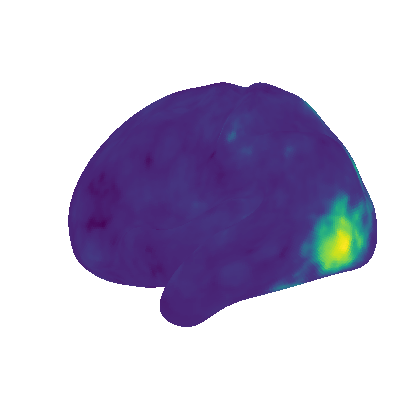

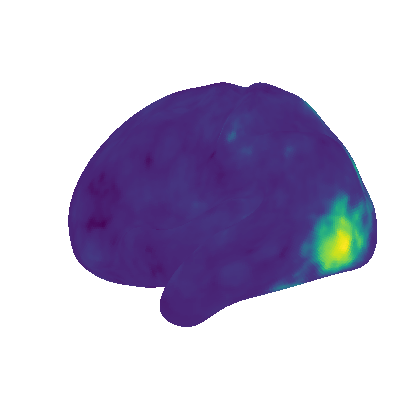

In [85]:
import hcp_utils as hcp # install hcp_utils in your virtual conda environment prior to this
import nilearn.plotting as plotting

plotting.plot_surf(surf_mesh = hcp.mesh.inflated_left, surf_map = fslr_lh.agg_data())

In [17]:
# schaefer 200
# note that it's easy to parcellate schaefer since the atlas is in MNI space just like the meta-analysis output

# get parcellations that we'll use to parcellate data
schaefer = fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)
labels = []
for i in range(len(schaefer['labels'])):
    labels.append(schaefer['labels'][i].decode("utf-8"))

# parcellate data and save to directory
parcellate_meta(modified_paths, schaefer['maps'],
                PARDIR / 'atl-schaefer2018_res-200_neurosynth.csv',
                regions=labels)
        

PosixPath('/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/derivatives/atl-schaefer2018_res-200_neurosynth.csv')

Use neuromaps to convert all z-score maps (.nii.gz) to surface space

In [53]:
from neuromaps.datasets import fetch_annotation

neurosynth = '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/visual_perception/z_desc-specificity_level-voxel_corr-FDR_method-indep.nii.gz'

In [12]:
neurosynth 

'/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/working_memory/z_desc-specificity_level-voxel_corr-FDR_method-indep.nii.gz'

In [54]:
fslr = transforms.mni152_to_fslr(neurosynth, '32k')
fslr_lh, fslr_rh = fslr

In [14]:
print(fslr)

(<nibabel.gifti.gifti.GiftiImage object at 0x117ef6910>, <nibabel.gifti.gifti.GiftiImage object at 0x298c11820>)


In [55]:

# Specify the output file names for each gifti
out_dir = '/Users/audluo/PennLINC/tractmaps/tractmaps/neurosynth/data/raw/neurosynth/visual_perception/'
output_files = ("output_file_lh.shape.gii", "output_file_rh.shape.gii")   

for gifti_image, output_file in zip(fslr, output_files):
    nib.save(gifti_image, os.path.join(out_dir, output_file))
    print(f"GiftiImage saved to {output_file}")

GiftiImage saved to output_file_lh.shape.gii
GiftiImage saved to output_file_rh.shape.gii


In [18]:
# may not use

# parcellate data and save to directory
parcellate_meta(modified_paths[1:3], glasser_atlas,
                PARDIR / 'atl-glasser_hcp.mmp_neurosynth.csv',
                regions=glasser_labels)

'/Users/audluo/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'

In [194]:
outputs = modified_paths[1:3]
annots = schaefer['maps']
fname = PARDIR / 'atl-glasser_hcp.mmp_neurosynth_TEST.csv',
regions = glasser_labels

#def parcellate_meta(outputs, annots, fname, regions):
# empty dataframe to hold our parcellated data
data = pd.DataFrame(index=regions)
mask = NiftiLabelsMasker(annots, resampling_target='data') # seems to get the timeseries data or something


outdir = outputs[1]

cdata = []
mgh = outdir / 'z_desc-specificity_level-voxel_corr-FDR_method-indep.nii.gz'

cdata.append(mask.fit_transform(check_niimg(mgh.__str__(), atleast_4d=True)).squeeze())

mask.fit_transform(check_niimg(mgh.__str__(), atleast_4d=True)).squeeze() # fits mask to input data, aka the neurosynth 

 
 

<bound method BaseEstimator.get_params of NiftiLabelsMasker(labels_img='/Users/audluo/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')>

Download the parcellated `.csv` to upload back into your drive.
Note you can also download the raw volumetric images from `./data/raw/neurosynth/term-of-interest/association-test_z.nii.gz`